# Proyecto Inteligencia Computacional - Proyecto 8 - ID 8a

## Integrantes
- Juan Pablo Contreras
- Pascual Marcone

## Ayudante
- Sebastian Guzman

# Dependencias

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
from torch.utils.data import TensorDataset
importlib.reload(src)

<module 'src' (namespace) from ['c:\\Users\\pmarc\\.conda\\envs\\inteli_gpu\\src', 'c:\\Users\\pmarc\\Universidad\\inteli\\ZTF_alert_8a\\src']>

# Data access

In [2]:
#load everything
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')
# dataset_2_28 = pd.read_pickle('data/stamp_dataset_28.pkl')
# dataset_2_45 = pd.read_pickle('data/stamp_dataset_45.pkl')
# dataset_1_45 = pd.read_pickle('data/stamp_dataset_jun_allwise_45_final.pkl')
# dataset_2_63 = pd.read_pickle('data/stamp_dataset_only_images_63.pkl')
# dataset_1_63 = pd.read_pickle('data/td_ztf_stamp_17_06_20.pkl')

In [34]:
dataset_1_21['Train'].keys()

dict_keys(['images', 'features', 'oid', 'class'])

In [3]:
#changing all labels to match for ease of use in the future
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

# apply the function to 
rename_labels(stamps_dataset, 'labels', 'class')
# rename_labels(dataset_1_63, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

Dataset size: 150000
Image shape: torch.Size([1, 21, 21])


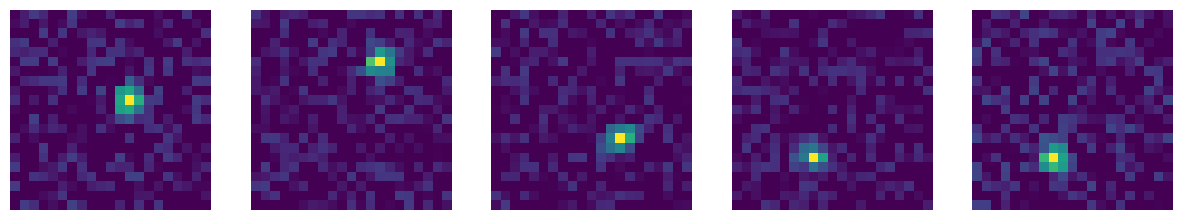

In [130]:
from torch.utils.data import TensorDataset

def generate_gaussian_image(size, center, sigma=1.0, noise_level=0.1, brightness=1.0, base_level=0.212):
    """Genera una imagen de tamaño `size` con una distribución gaussiana centrada en `center` 
    y un nivel base de `base_level`."""
    
    # Crear coordenadas
    x = np.linspace(0, size-1, size)
    y = np.linspace(0, size-1, size)
    x, y = np.meshgrid(x, y)
    
    # Calcular la distancia desde el centro y la función gaussiana
    d = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    g = np.exp(-(d**2 / (2.0 * sigma**2)))
    
    # Ajustar el brillo
    g *= brightness
    
    # Establecer el valor base mínimo
    g = base_level + (1 - base_level) * g  # Ajustar la gaussiana para que esté en el rango [base_level, 1]
    
    # Agregar ruido uniforme que parte desde el base_level
    noise = np.random.uniform(-noise_level, noise_level, g.shape)
    g += noise
    # Asegurarse de que los valores estén en el rango [base_level, 1]
    g = np.clip(g, base_level, 1)
    g = (g - g.min()) / (g.max() - g.min())
    return g

def generate_gaussian_dataset(num_samples, image_size, border_margin=3, noise_level=0.1, brightness=1.0):
    """Genera un dataset de imágenes gaussianas con centros aleatorios."""
    images = []
    for _ in range(num_samples):
        center = (np.random.randint(border_margin, image_size - border_margin), 
                  np.random.randint(border_margin, image_size - border_margin))
        image = generate_gaussian_image(image_size, center, noise_level=noise_level, brightness=brightness)
        images.append(image)
    images = np.array(images)
    images = images[:, np.newaxis, :, :]  # Añadir una dimensión para el canal
    return torch.tensor(images, dtype=torch.float32)

# Parámetros del dataset
num_samples = 150000
image_size = 21
border_margin = 4
noise_level = 0.1
brightness = 0.7

# Generar el dataset
gaussian_images = generate_gaussian_dataset(num_samples, image_size, border_margin, noise_level, brightness)

# Crear un TensorDataset
gaussian_dataset = TensorDataset(gaussian_images)


# Verificar el tamaño del dataset
print(f"Dataset size: {len(gaussian_dataset)}")
print(f"Image shape: {gaussian_dataset[0][0].shape}")

# Visualizar algunas imágenes
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image = dataset[i][0].numpy().squeeze()  # Convertir a numpy y eliminar la dimensión del canal
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# Mostrar 10 imágenes del dataset
show_images(gaussian_dataset, num_images=5)

## Data Characterization

In [5]:
from anytree import Node, RenderTree

# stamps_dataset
root = Node(f"stamps_dataset -- {stamps_dataset['Train']['images'].shape}")
train = Node("Train", parent=root)
validation = Node("validation", parent=root)
test = Node("Test", parent=root)

labels = Node("labels", parent=train)
images = Node("images", parent=train)
template = Node("template", parent=train)
difference = Node("difference", parent=train)

s_labels = Node("labels", parent=validation)
s_images = Node("images", parent=validation)
s_template = Node("template", parent=validation)
s_difference = Node("difference", parent=validation)

t_labels = Node("labels", parent=test)
t_images = Node("images", parent=test)
t_template = Node("template", parent=test)
t_difference = Node("difference", parent=test)

# Render the tree
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print('\n')

ModuleNotFoundError: No module named 'anytree'

# Visualizacion Datos

Analizando algunos ejemplos de cada una

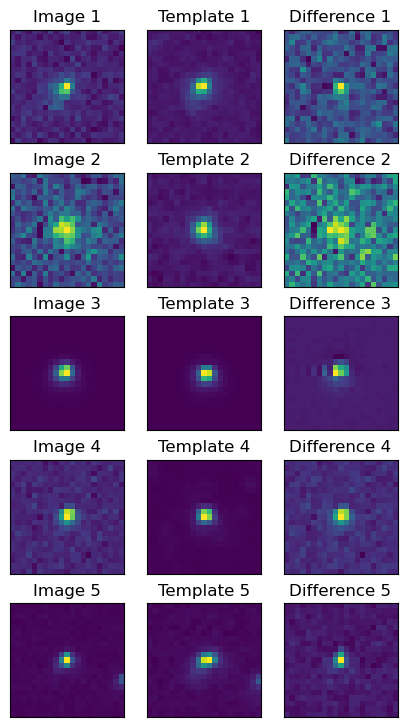

In [6]:
import src.plots as plots
importlib.reload(plots)

plots.plot_example(stamps_dataset, n = 5)

# Data Loader

In [116]:
train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
train_class = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)

validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
validation_class = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)

test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)
test_class = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

train_difference = (train_difference - train_difference.min()) / (train_difference.max() - train_difference.min())
validation_difference = (validation_difference - validation_difference.min()) / (validation_difference.max() - validation_difference.min())
test_difference = (test_difference - test_difference.min()) / (test_difference.max() - test_difference.min())


# Reshape the arrays
num_samples, num_photos, height, width = train_difference.shape

reshaped_train_difference = train_difference.reshape(num_samples * num_photos, 1, height, width)
reshaped_train_class = train_class.repeat_interleave(num_photos)


num_samples, num_photos, height, width = validation_difference.shape

reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, 1, height, width)
reshaped_val_class = validation_class.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape

reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, 1, height, width)
reshaped_test_class = test_class.repeat_interleave(num_photos)

train_dataset = TensorDataset(reshaped_train_difference, reshaped_train_class)
validation_dataset = TensorDataset(reshaped_val_difference, reshaped_val_class)
test_dataset = TensorDataset(reshaped_test_difference, reshaped_test_class)

# Obtener los tensores subyacentes
train_tensors = train_dataset.tensors

# Imprimir la forma de cada tensor en el dataset
for i, tensor in enumerate(train_tensors):
    print(f"Shape of tensor {i}: {tensor.shape}")

Shape of tensor 0: torch.Size([616135, 1, 21, 21])
Shape of tensor 1: torch.Size([616135])


In [100]:
print(dataset_1_21["Validation"]["images"].shape)


(500, 21, 21, 3)


In [4]:
train_difference = torch.tensor(dataset_1_21['Train']['images'], dtype=torch.float32)
train_class = torch.tensor(dataset_1_21['Train']['class'], dtype=torch.float32)

validation_difference = torch.tensor(dataset_1_21['Validation']['images'], dtype=torch.float32)
validation_class = torch.tensor(dataset_1_21['Validation']['class'], dtype=torch.float32)

test_difference = torch.tensor(dataset_1_21['Test']['images'], dtype=torch.float32)
test_class = torch.tensor(dataset_1_21['Test']['class'], dtype=torch.float32)

train_difference = (train_difference - train_difference.min()) / (train_difference.max() - train_difference.min())
validation_difference = (validation_difference - validation_difference.min()) / (validation_difference.max() - validation_difference.min())
test_difference = (test_difference - test_difference.min()) / (test_difference.max() - test_difference.min())


# Seleccionar los canales 0 y 2
train_difference_reshaped = train_difference[:, :, :, [0, 2]]
validation_difference_reshaped = validation_difference[:, :, :, [0, 2]]
test_difference_reshaped = test_difference[:, :, :, [0, 2]]

# Permutar las dimensiones para que tengan la forma [batch_size, num_channels, height, width]
train_difference_reshaped_perm = train_difference_reshaped.permute(0, 3, 1, 2)
validation_difference_reshaped_perm = validation_difference_reshaped.permute(0, 3, 1, 2)
test_difference_reshaped_perm = test_difference_reshaped.permute(0, 3, 1, 2)

# Verificar las nuevas formas de los tensores
print(f"Train shape: {train_difference_reshaped.shape}")
print(f"Validation shape: {validation_difference_reshaped.shape}")
print(f"Test shape: {test_difference_reshaped.shape}")




train_dataset = TensorDataset(train_difference_reshaped_perm, train_class)
validation_dataset = TensorDataset(validation_difference_reshaped_perm, validation_class)
test_dataset = TensorDataset(test_difference_reshaped_perm, test_difference)



Train shape: torch.Size([72710, 21, 21, 2])
Validation shape: torch.Size([500, 21, 21, 2])
Test shape: torch.Size([500, 21, 21, 2])


In [ ]:
import src.model.train as train
importlib.reload(train)
import src.model.metrics as metrics
importlib.reload(metrics)
import src.model.vae as vae
importlib.reload(vae)

model_full = vae.VAE(latent_dim=21, n_channels=2)

max_epochs = 700
criterion = vae.loss_function
batch_size = 100 #100
lr = 0.333e-4 #propuesto en paper astorga
early_stop = 100
use_gpu = True

curves_full, tiempo_ejecucion_full = train.train_model(model_full,
                                            train_dataset,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            augmentation=True,
                                            use_gpu=use_gpu)

Augmenting Data...


C:\Users\pmarc\AppData\Local\Temp\ipykernel_25792\1650614945.py:17: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 10
  plt.legend(handles=scatter.legend_elements()[0], labels=[str(i) for i in range(10)], title="Digits")


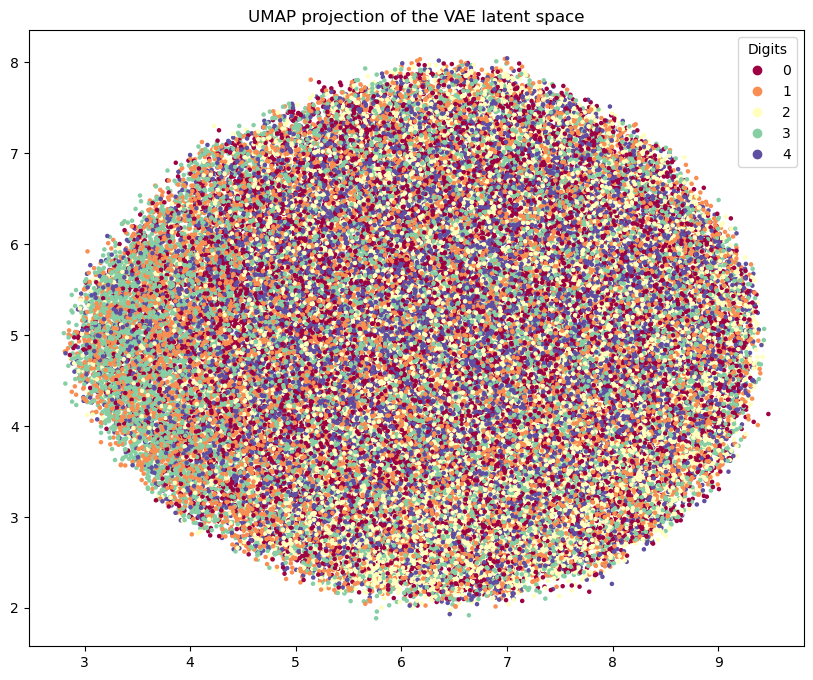

In [49]:
# armar test dataset
from torch.utils.data import TensorDataset, DataLoader
import umap

model_full.eval()

z_test = model_full.only_encoder(train_difference_reshaped_perm).detach().numpy()
z_label = train_class.detach().numpy()

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='correlation')
embedding = reducer.fit_transform(z_test)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=z_label, cmap='Spectral', s=5)
plt.title('UMAP projection of the VAE latent space')
plt.legend(handles=scatter.legend_elements()[0], labels=[str(i) for i in range(10)], title="Digits")
plt.show()

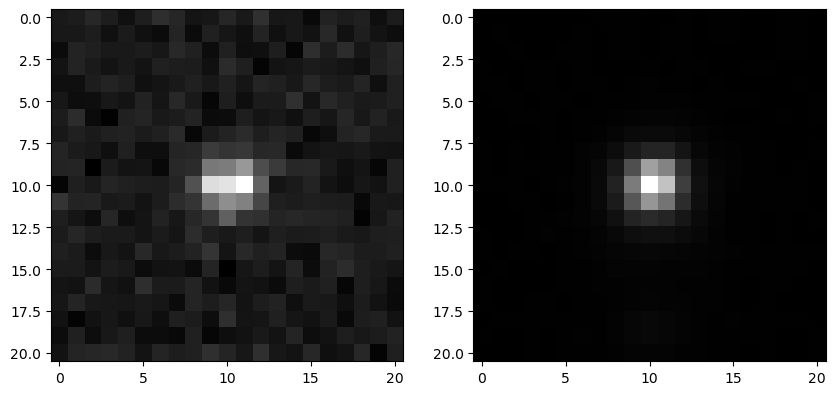

(1, 2, 21, 21)


C:\Users\pmarc\AppData\Local\Temp\ipykernel_25792\3586523557.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img).unsqueeze(0)


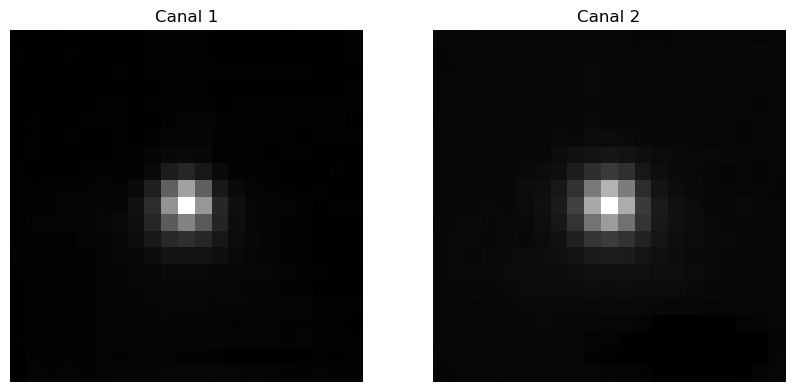

: 

In [83]:
import src.plots as plots
importlib.reload(plots)
ind = np.random.randint(0, len(test_difference_reshaped_perm))
img = test_difference_reshaped_perm[ind]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0,:, :], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img[1,:, :], cmap='gray')
plt.show()

models = [model_full]  
datasets = test_difference_reshaped_perm
img_tensor = torch.tensor(img).unsqueeze(0)
reconstructed_img = model_full(img_tensor)
reconstructed_img = reconstructed_img[0].detach().numpy()


print(reconstructed_img.shape)

reconstructed_img = reconstructed_img[0] 
plt.figure(figsize=(10, 5))

# Mostrar el primer canal
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_img[0, :, :], cmap='gray')
plt.title('Canal 1')
plt.axis('off')

# Mostrar el segundo canal
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img[1, :, :], cmap='gray')
plt.title('Canal 2')
plt.axis('off')

plt.show()



# Entrenamiento de Modelo

In [105]:
import src.model.train as train
importlib.reload(train)
import src.model.metrics as metrics
importlib.reload(metrics)
import src.model.vae as vae
importlib.reload(vae)

<module 'src.model.vae' from '/home/juanpablo/universidad/proyecto/ZTF_alert_8a/src/model/vae.py'>

In [9]:
#datasets de modelos
indices1 = torch.randperm(len(reshaped_train_difference))[:500]
indices2 = torch.randperm(len(reshaped_train_difference))[:1000]
indices3 = torch.randperm(len(reshaped_train_difference))[:4000]
indices4 = torch.randperm(len(reshaped_train_difference))[:8000]
indices5 = torch.randperm(len(reshaped_train_difference))[:15000]

train_dataset_1 = TensorDataset(reshaped_train_difference[indices1], reshaped_train_class[indices1])

train_dataset_2 = TensorDataset(reshaped_train_difference[indices2], reshaped_train_class[indices2])

train_dataset_3 = TensorDataset(reshaped_train_difference[indices3], reshaped_train_class[indices3])

train_dataset_4 = TensorDataset(reshaped_train_difference[indices4], reshaped_train_class[indices4])

train_dataset_5 = TensorDataset(reshaped_train_difference[indices5], reshaped_train_class[indices5])

# Generar un dataset gaussiano para entrenamiento
fake_classes = torch.randint(0, 2, (gaussian_images.shape[0],))
train_gaussian_dataset = TensorDataset(gaussian_images[5000:], fake_classes[5000:])
val_gaussian_dataset = TensorDataset(gaussian_images[:5000], fake_classes[:5000])

In [10]:
model_full = vae.VAE(latent_dim=21)
model_gauss_full = vae.VAE(latent_dim=21)

max_epochs = 80
criterion = vae.loss_function
batch_size = 100 #100
lr = 0.333e-4
early_stop = 100
use_gpu = True

curves_full, tiempo_ejecucion_full = train.train_model(model_full,
                                            train_dataset,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_gauss_full, tiempo_ejecucion_gauss_full = train.train_model(model_gauss_full,
                                            train_gaussian_dataset,
                                            val_gaussian_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

Epoch 80/80 -- Iteration 491933 - Batch 5135/6162 - Train loss: 265.327820

Epoch 80/80 -- Iteration 115996 - Batch 1446/1450 - Train loss: 220.403122



In [11]:
torch.save(model_full.state_dict(), 'models/model_full.pth')
torch.save(model_gauss_full.state_dict(), 'models/model_gauss_full.pth')


: 

In [16]:
model_0 = vae.VAE(latent_dim=21)
model_1 = vae.VAE(latent_dim=21)
model_2 = vae.VAE(latent_dim=21)
model_3 = vae.VAE(latent_dim=21)
model_4 = vae.VAE(latent_dim=21)
model_5 = vae.VAE(latent_dim=21)
model_gaus = vae.VAE(latent_dim=21)

max_epochs = 50
criterion = vae.loss_function
batch_size = 64 #100
lr = 1e-4
early_stop = 20
use_gpu = False

curves_1, tiempo_ejecucion_1 = train.train_model(model_1,
                                            train_dataset_1,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_2, tiempo_ejecucion_2 = train.train_model(model_2,
                                            train_dataset_2,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_3, tiempo_ejecucion_3 = train.train_model(model_3,
                                            train_dataset_3,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_4, tiempo_ejecucion_4 = train.train_model(model_4,
                                            train_dataset_4,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_5, tiempo_ejecucion_5 = train.train_model(model_5,
                                            train_dataset_5,
                                            validation_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

curves_gaus, tiempo_ejecucion_gaus = train.train_model(model_gaus,
                                            train_gaussian_dataset,
                                            val_gaussian_dataset,
                                            test_dataset,
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

print(f'\nTiempo de ejecución -- model_1: {tiempo_ejecucion_1:.0f} -- model_2: {tiempo_ejecucion_2:.0f} -- model_3: {tiempo_ejecucion_3:.0f} -- model_4: {tiempo_ejecucion_4:.0f} -- model_5: {tiempo_ejecucion_5:.0f} -- model_gauss: {tiempo_ejecucion_gaus:.0f}')

Epoch 17/50 -- Iteration 135 - Batch 7/8 - Train loss: 442.626251

In [121]:
import os
if not os.path.exists('models'):
    os.makedirs('models')

torch.save(model_1.state_dict(), 'models/model_1.pth')
torch.save(model_2.state_dict(), 'models/model_2.pth')
torch.save(model_3.state_dict(), 'models/model_3.pth')
torch.save(model_4.state_dict(), 'models/model_4.pth')
torch.save(model_5.state_dict(), 'models/model_5.pth')
torch.save(model_gaus.state_dict(), 'models/model_gaus.pth')

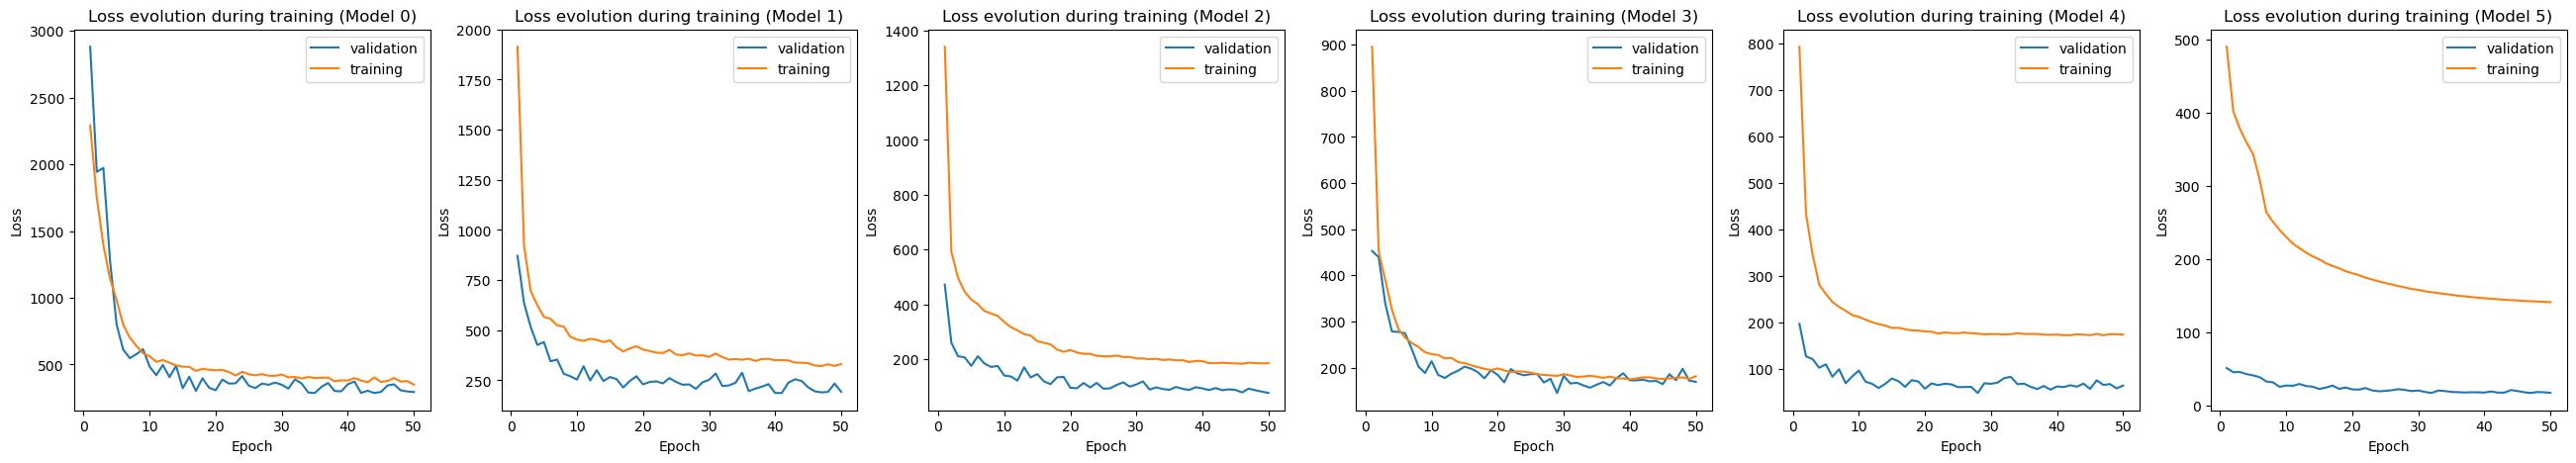

In [122]:
import src.model.metrics as metrics
importlib.reload(metrics)

fig = metrics.show_loss(curves_1, curves_2, curves_3, curves_4, curves_5, curves_gaus)

# Ejemplos

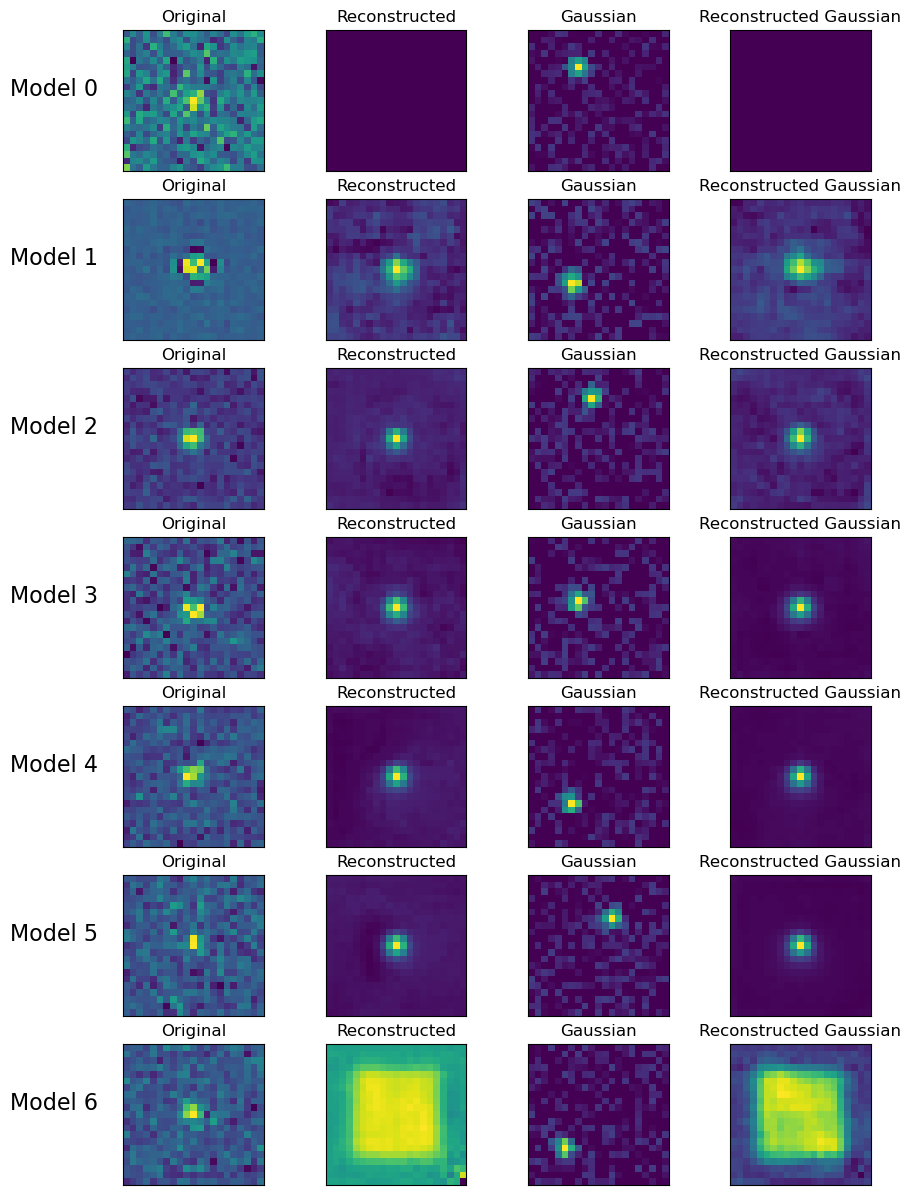

In [124]:
import src.plots as plots
importlib.reload(plots)

models = [model_0, model_1, model_2, model_3, model_4, model_5, model_gaus]  
datasets = test_difference

plots.plot_train_example(models, datasets, gaussian_dataset)